In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jun 21 16:14:20 2023

@author: poojap

This program will combine transformed proteomic data and the output of the
spatial proteomic analysis with modules specified. The entrez ID and module
membership will also be detailed.

"""
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
currdir = os.getcwd()
parent = os.path.dirname(currdir)
gparent = os.path.dirname(parent)


In [3]:
gene_analyzing = "SNCA"

print("current directory: ", currdir)

transformedfile = f"LOPIT_{gene_analyzing}_young_Transformed.csv"
module_results_file = f"{gene_analyzing}-TMT-Module-Results.xlsx"

# CHANGE TO YOUR VARIABLES
wildtype = "WildType"
mutant = "Transgenic"

mixture_to_analyze = "M1"
significant_module = 7

current directory:  /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/compare_MutvsWTfractions


In [4]:
def ensure_dirs_exists(path):
    if "." in path:
        path = os.path.dirname(path)
    if not os.path.exists(path):
        os.makedirs(path)
    return

In [5]:
def read_files(gene_analyzing, transformedfile, module_results_file):
    # change to point to your directory and appropriate pre-processed file
    transformeddata_df = pd.read_csv(f"{parent}/transformeddata/{transformedfile}")
    partition_df = pd.read_excel(f"{parent}/tables/{module_results_file}")
    return gene_analyzing, transformeddata_df, partition_df

geneAnalysis, transforrmeddatadf, partition_df = read_files(gene_analyzing, transformedfile, module_results_file)

In [6]:
print(transforrmeddatadf.columns)
transforrmeddatadf.head()


Index(['Unnamed: 0', 'Protein', 'Gene', 'Function', 'Origin', 'Mixture',
       'Genotype', 'BioFraction', 'Intensity', 'Abundance', 'Rel_Intensity'],
      dtype='object')


,Unnamed: 0,Protein,Gene,Function,Origin,Mixture,Genotype,BioFraction,Intensity,Abundance,Rel_Intensity
0,0,A2AG50,Map7d2,MAP7 domain-containing protein 2,Mus musculus,M1,WildType,F4,142.745198,7.157298,0.011425
1,1,A2AHC3,Camsap1,Calmodulin-regulated spectrin-associated prote...,Mus musculus,M1,WildType,F4,27.799601,4.796992,0.020036
2,2,A2AR02,Ppig,Peptidyl-prolyl cis-trans isomerase G,Mus musculus,M1,WildType,F4,62.546158,5.966849,0.006950
3,3,AXXXXX,man,human alpha-synuclein with Parkinson's mutation,man alpha-synuclein with Parkinson's mutation,M1,WildType,F4,24.000628,4.585000,0.002598
4,4,B2RSH2,Gnai1,Guanine nucleotide-binding protein G(i) subuni...,Mus musculus,M1,WildType,F4,319.895170,8.321455,0.057079


In [7]:
partition_df.head()

,UniProt,Entrez,Symbol,Membership
0,P11404,14077,Fabp3,0
1,P62814,11966,Atp6v1b2,0
2,Q920I9,104082,Wdr7,0
3,Q9QYC0,11518,Add1,0
4,Q9Z277,22385,Baz1b,0


In [8]:
def merge_dataframes(transformed_data, partition_module_data):
    alldata = pd.DataFrame()
    alldata = pd.merge(transformed_data, partition_module_data, left_on=("Gene"),
                       right_on = ("Symbol"))
    alldata = alldata.drop(columns=["Symbol", "UniProt"], axis = 1)
    write_to = f"{parent}/tables/{gene_analyzing}_data_with_membership.csv"
    
    # alldata is shorter than transformed because alldata is filtered to only mus musculus
    alldata.to_csv(write_to, index = False)
    ensure_dirs_exists(write_to)
    return alldata
alldata_df = merge_dataframes(transforrmeddatadf, partition_df)

In [9]:
def drop_irrelevant_cols(alldata_df):
    ##### Time for data analysis ################
    colstodrop = ["Origin", "Function", "Entrez"]
    newdf = alldata_df.drop(colstodrop, axis = 1)
    newdf.head()
    return newdf
newdf = drop_irrelevant_cols(alldata_df)

In [10]:
def pick_module(significant_module):
    # Change below to your significant module sheet!
    sheet_name = "Module Results"
    module_details_df = pd.read_excel(f"{parent}/tables/{module_results_file}",
                                      sheet_name=sheet_name)
    sigmodules = module_details_df[module_details_df["candidate"] == True]["Module"].values
    print(f"Significant Modules in this dataset: {sigmodules}\n")

    # Handling when a specific module is specified
    if significant_module is not None:
        # Ensuring the module prefix "M" is correctly formatted
        module_id = f"M{significant_module}" if isinstance(significant_module, int) else significant_module
        nprots = int(module_details_df[module_details_df["Module"] == module_id]["nProts"].values[0])
        pAdjustScore = float(module_details_df[module_details_df["Module"] == module_id]["Padjust"].values[0])
        print(f"Number of proteins in module {module_id}: {nprots}\n")
        print(f"PadjustScore for module {module_id}: {pAdjustScore}\n")
    else:
        # Default values when no specific module is specified
        nprots = None
        pAdjustScore = None

    return module_details_df, nprots, pAdjustScore, sigmodules
module_details_df, nprots, pAdjustScore, sign_modules = pick_module(None)

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']



In [11]:
def analyze_data(newdf, wildtype, mutant, sigmodule):
    proteins = []
    genes = []
    fractions = []
    mixtures = []
    
    print(f"In this dataset, the wildtype is classified as '{wildtype}' and the mutant is classified as '{mutant}'")
    ##### For some reason some genes not in OG set are added during module <- FIXME
    ## analysis. These extra genes are taken out when mapped to OG data, but
    ### that is why there may be some disecrepancy in the quantity 

    for ind, val in enumerate(newdf["Membership"]):
        if val == sigmodule:
            proteins.append(newdf["Protein"][ind])
            genes.append(newdf["Gene"][ind])
            fractions.append(newdf["BioFraction"][ind])
            mixtures.append(newdf["Mixture"][ind])

    proteins = list(set(proteins))
    genes = list(set(genes))
    fractions = list(set(fractions))
    fractions = sorted(fractions, key=lambda x: int(x.strip('F ').strip()))
    mixtures = list(set(mixtures))
    mixtures = sorted(mixtures, key=lambda x: int(x.strip('M ').strip()))
    return proteins, genes, fractions, mixtures
proteins, genes, fractions, mixtures = analyze_data(newdf, wildtype, mutant, significant_module)

In this dataset, the wildtype is classified as 'WildType' and the mutant is classified as 'Transgenic'


In [12]:
def pull_Module_WT_data(newdf, proteins, genes, fractions, mixtures):
    wt_dictionary = {}
    for gene in tqdm(genes, desc="iterating through genes in WT proteome"):
        ind = newdf[newdf["Gene"] == gene].index
        gene_mixtures = {}
        for i in ind:
            if newdf["Genotype"][i] == wildtype:
                for mix in mixtures:
                    if newdf["Mixture"][i] == mix:
                        gene_biofractions = []
                        for frac in fractions:
                            val = newdf[(newdf["BioFraction"] == frac) & (newdf["Gene"] == gene) &
                                        (newdf["Genotype"] == wildtype) & (newdf["Mixture"] == mix)]["Rel_Intensity"].values
                            gene_biofractions.extend(val)    
                        gene_mixtures[mix] = gene_biofractions
                wt_dictionary[gene] = gene_mixtures
    return wt_dictionary
wildtype_dict = pull_Module_WT_data(newdf, proteins, genes, fractions, mixtures)

iterating through genes in WT proteome: 100%|██████████| 40/40 [00:15<00:00,  2.51it/s]


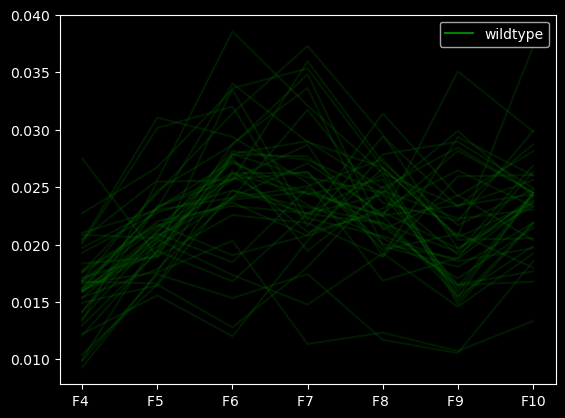

In [13]:
def plot_wt(wildtype_dictionary, fractions, mixture_to_analyze):
    fig, ax = plt.subplots()
    mixturevals = []
    for ind, gene in enumerate(wildtype_dictionary.keys()):
        # only plotting M1, if you would like to pick another mixture you may.
        mixturevals = (list(wildtype_dictionary[gene][mixture_to_analyze]))
        
        ax.plot(fractions, mixturevals, color = "green", alpha = 0.2)
    green_line = plt.Line2D([0], [0], color='green', label='wildtype')
    ax.legend(handles=[green_line])
    return
plot_wt(wildtype_dict, fractions, mixture_to_analyze)

In [14]:
def pull_Module_MUT_data(newdf, proteins, genes, fractions, mixtures):
    mut_dictionary = {}
    for gene in tqdm(genes, desc="iterating through genes in MUT proteome"):
        ind = newdf[newdf["Gene"] == gene].index
        gene_mixtures = {}
        for i in ind:
            if newdf["Genotype"][i] == wildtype:
                for mix in mixtures:
                    if newdf["Mixture"][i] == mix:
                        gene_biofractions = []
                        for frac in fractions:
                            val = newdf[(newdf["BioFraction"] == frac) & (newdf["Gene"] == gene) &
                                        (newdf["Genotype"] == mutant) & (newdf["Mixture"] == mix)]["Rel_Intensity"].values
                            gene_biofractions.extend(val)    
                        gene_mixtures[mix] = gene_biofractions
                mut_dictionary[gene] = gene_mixtures
    return mut_dictionary
mutant_dict = pull_Module_MUT_data(newdf, proteins, genes, fractions, mixtures)

iterating through genes in MUT proteome: 100%|██████████| 40/40 [00:15<00:00,  2.50it/s]


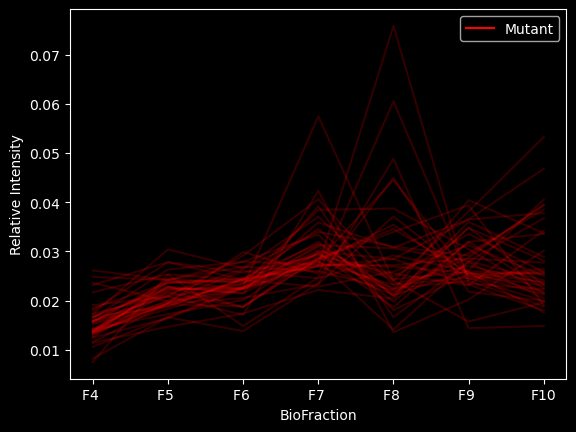

In [15]:
def plot_MUT(mut_dictionary, fractions, mixture_to_analyze):
    ax = plt.gca()
    mut_mixtures = []
    for gene in mut_dictionary.keys():
        # only plotting M1, if you would like to pick another mixture you may.
        mut_mixtures = (list(mut_dictionary[gene][mixture_to_analyze]))
        ax.plot(fractions, mut_mixtures, color = "red", alpha = 0.2)

    red_line = plt.Line2D([0], [0], color='red', label='Mutant')
    ax.legend(handles=[red_line])

    ax.set_xlabel("BioFraction")
    ax.set_ylabel("Relative Intensity") 
    plt.show()
    return
plot_MUT(mutant_dict, fractions, mixture_to_analyze)

In [16]:
## Function for scientific notation
def as_sn(number):
    formatted_number = "{:.2e}".format(number)
    formatted_number = formatted_number.replace('e', 'x10')
    exponent_start = formatted_number.index('x10') + len('x10')
    
    exponent = formatted_number[exponent_start:]
    if "-" in exponent:
        exponent = exponent.translate(str.maketrans('-0123456789', '⁻⁰¹²³⁴⁵⁶⁷⁸⁹'))
    else:
        exponent = exponent.translate(str.maketrans('+0123456789', '⁺⁰¹²³⁴⁵⁶⁷⁸⁹'))


    formatted_number = formatted_number[:exponent_start]  + exponent
    return formatted_number
form = as_sn(1.399393e22)
print(form)


1.40x10⁺²²


In [17]:
nprots

analyzing ONLY mixture M1


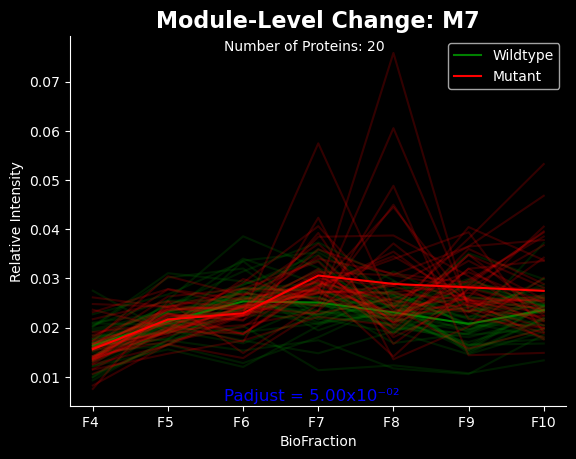

In [19]:
def plot_MUTWT_1mix(wt_dictionary, mut_dictionary, significant_module, pAdjustScore, nProts, fractions, mixture_to_analyze):
    fig, ax = plt.subplots()
    print(f"analyzing ONLY mixture {mixture_to_analyze}")

    WT, Mut = [], []

    # Determine the alpha value based on the number of proteins
    if nProts < 50:
        alpha = 0.2
    elif 50 <= nProts <= 100:
        alpha = 0.1
    else:  # nProts >= 101
        alpha = 0.08

    # Processing Wild Type data
    for gene in wt_dictionary.keys():
        wt_mixturevals = list(wt_dictionary[gene][mixture_to_analyze])
        WT.append(wt_mixturevals)
        ax.plot(fractions, wt_mixturevals, color="green", alpha=alpha)
    WT_average = np.mean(WT, axis=0)
    ax.plot(fractions, WT_average, color="green")

    # Processing Mutant data
    for gene in mut_dictionary.keys():
        mut_mixtures = list(mut_dictionary[gene][mixture_to_analyze])
        Mut.append(mut_mixtures)
        ax.plot(fractions, mut_mixtures, color="red", alpha=alpha)
    MUT_average = np.mean(Mut, axis=0)
    ax.plot(fractions, MUT_average, color="red")

    # Add legends
    green_line = plt.Line2D([0], [0], color='green', label='Wildtype')
    red_line = plt.Line2D([0], [0], color='red', label='Mutant')
    ax.legend(handles=[green_line, red_line])

    directory = f"{gene_analyzing}_Mixture{mixture_to_analyze}"
    

    # Plot formatting and saving
    ax.set_xlabel("BioFraction")
    ax.set_ylabel("Relative Intensity")  # FIXME: Needs normalization to log2scale
    ax.set_title(f"Module-Level Change: M{significant_module}", fontsize=16, fontweight="bold")
    ymin, ymax = plt.ylim()
    plt.text(1.75, ymin + 0.001, f'Padjust = {as_sn(float(pAdjustScore))}', fontsize=12, color='blue')
    plt.text(1.75, ymax - 0.003, f"Number of Proteins: {nProts}", fontsize=10)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    savefigure = f"{directory}/{gene_analyzing}_Module{significant_module}_Mixture{mixture_to_analyze}.png"
    ensure_dirs_exists(savefigure)
    plt.savefig(savefigure)
    
    
    return WT, Mut, mixture_to_analyze
WT, MUT, mixture_to_analyze = plot_MUTWT_1mix(wildtype_dict, mutant_dict, significant_module, 0.05, 20, fractions,
                                              mixture_to_analyze)

analyzing ONLY mixture M1
7 ###################
Directory 'SNCA_MixtureM1' already exists.
SNCA_MixtureM1/SNCA_Module7_MixtureM1.png file created!
This is the filepath /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/compare_MutvsWTfractions/SNCA_MixtureM1/SNCA_Module7_MixtureM1.png


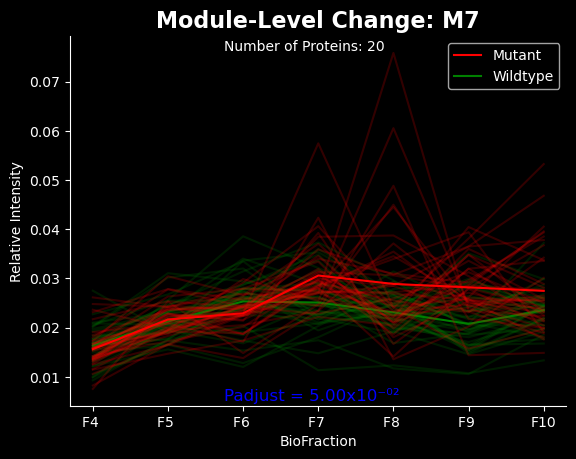

In [22]:
# def plot_MUTWT_1mix(wt_dictionary, mut_dictionary, significant_module, pAdjustScore, nProts, fractions, mixture_to_analyze):
#         ## both together
#     fig, ax = plt.subplots()
#     print(f"analyzing ONLY mixture {mixture_to_analyze}")
#     WT = []
#     if nProts < 50:
#         for ind, gene in enumerate(wt_dictionary.keys()):
#             # only plotting M1, if you would like to pick another mixture you may.
#             wt_mixturevals = (list(wt_dictionary[gene][mixture_to_analyze]))
#             WT.append((list(wt_dictionary[gene][mixture_to_analyze])))
#             ax.plot(fractions, wt_mixturevals, color = "green", alpha = 0.2)
#         WT_average = np.mean(WT, axis = 0)
#         ax.plot(fractions, WT_average, color = "green")

#         green_line = plt.Line2D([0], [0], color='green', label='Wildtype')
#         ax.legend(handles=[green_line])
#         Mut = []
#         for gene in mut_dictionary.keys():
#             # only plotting M1, if you would like to pick another mixture you may.
#             mut_mixtures = (list(mut_dictionary[gene][mixture_to_analyze]))
#             Mut.append((list(mut_dictionary[gene][mixture_to_analyze])))
#             ax.plot(fractions, mut_mixtures, color = "red", alpha = 0.2)
#         MUT_average = np.mean(Mut, axis = 0)
#         ax.plot(fractions, MUT_average, color = "red")
#         red_line = plt.Line2D([0], [0], color='red', label='Mutant')
#         ax.legend(handles=[red_line, green_line])

#     elif 50 <= nProts <= 100:
#         for ind, gene in enumerate(wt_dictionary.keys()):
#             # only plotting M1, if you would like to pick another mixture you may.

#             wt_mixturevals = (list(wt_dictionary[gene][mixture_to_analyze]))
#             WT.append((list(wt_dictionary[gene][mixture_to_analyze])))
#             ax.plot(fractions, wt_mixturevals, color = "green", alpha = 0.1)
#         WT_average = np.mean(WT, axis = 0)


#         ax.plot(fractions, WT_average, color = "green")

#         green_line = plt.Line2D([0], [0], color='green', label='Wildtype')
#         ax.legend(handles=[green_line])
#         Mut = []
#         for gene in mut_dictionary.keys():
#             # only plotting M1, if you would like to pick another mixture you may.
#             mut_mixtures = (list(mut_dictionary[gene][mixture_to_analyze]))
#             Mut.append((list(mut_dictionary[gene][mixture_to_analyze])))
#             ax.plot(fractions, mut_mixtures, color = "red", alpha = 0.1)
#         MUT_average = np.mean(Mut, axis = 0)
#         ax.plot(fractions, MUT_average, color = "red")
#         red_line = plt.Line2D([0], [0], color='red', label='Mutant')
#         ax.legend(handles=[red_line, green_line])

#     elif nProts >= 101:
#         for ind, gene in enumerate(wt_dictionary.keys()):
#             # only plotting M1, if you would like to pick another mixture you may.
#             wt_mixturevals = (list(wt_dictionary[gene][mixture_to_analyze]))
#             WT.append((list(wt_dictionary[gene][mixture_to_analyze])))
#             ax.plot(fractions, wt_mixturevals, color = "green", alpha = 0.08)
#         WT_average = np.mean(WT, axis = 0)
#         ax.plot(fractions, WT_average, color = "green")

#         green_line = plt.Line2D([0], [0], color='green', label='Wildtype')
#         ax.legend(handles=[green_line])
#         Mut = []
#         for gene in mut_dictionary.keys():
#             # only plotting M1, if you would like to pick another mixture you may.
#             mut_mixtures = (list(mut_dictionary[gene][mixture_to_analyze]))
#             Mut.append((list(mut_dictionary[gene][mixture_to_analyze])))
#             ax.plot(fractions, mut_mixtures, color = "red", alpha = 0.08)
#         MUT_average = np.mean(Mut, axis = 0)
#         ax.plot(fractions, MUT_average, color = "red")
#         red_line = plt.Line2D([0], [0], color='red', label='Mutant')
#         ax.legend(handles=[red_line, green_line])
#     print(len(WT_average), "###################")

#     directory = f"{gene_analyzing}_Mixture{mixture_to_analyze}"
#     if not os.path.exists(directory):
#         os.makedirs(directory)
#         print(f"Directory '{directory}' created successfully.")
#     else:
#         print(f"Directory '{directory}' already exists.")
#     plot_size_inches = fig.get_size_inches()

#      # Get the current limits of the y-axis
#     ymin, ymax = plt.ylim()

#     # Retrieve the maximum value of the y-axis
#     max_y = ymax
#     min_y = ymin

#     ax.set_xlabel("BioFraction")
#     ax.set_ylabel("Relative Intensity")  ## FIXME -> needs to be normalized log2scale to be between 0-1
#     ax.set_title(f"Module-Level Change: M{significant_module}", fontsize = 16, fontweight = "bold")
#     plt.text(1.75 , ymin + 0.001, f'Padjust = {as_sn(float(pAdjustScore))}', fontsize=12, color='blue')
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['right'].set_visible(False)
#     plt.text(1.75, ymax - 0.003, f"Number of Proteins: {nProts}", fontsize = 10)
#     savefigure = f"{directory}/{gene_analyzing}_Module{significant_module}_Mixture{mixture_to_analyze}.png"
#     plt.savefig(savefigure)
#     if os.path.exists(savefigure):
#         print(f"{savefigure} file created!\n"
#              f"This is the filepath {os.path.abspath(savefigure)}")
#     plt.show()
#     return WT, Mut, mixture_to_analyze
# WT, MUT, mixture_to_analyze = plot_MUTWT_1mix(wildtype_dict, mutant_dict, significant_module, 0.05, 20, fractions, mixture_to_analyze)

analyzing ALL mixtures: ['M1', 'M2', 'M3']
60 7
Directory 'SNCA_MixturesAveraged' already exists.
SNCA_MixturesAveraged/SNCA_Module5_MixturesAveraged.png file created!
This is the filepath /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/compare_MutvsWTfractions/SNCA_MixturesAveraged/SNCA_Module5_MixturesAveraged.png


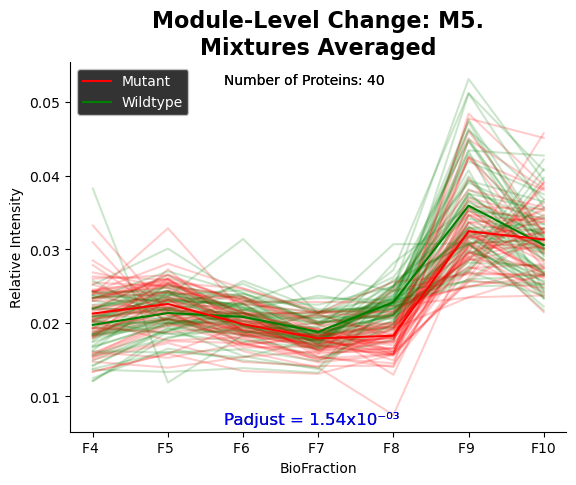

In [60]:
def find_avg_plots(wt_dictionary, mut_dictionary, significant_module, pAdjustScore, nProts, mixtures):
     ## both together
    print(f"analyzing ALL mixtures: {mixtures}")
    fig, ax = plt.subplots()
#     WT_lists = [[] for _ in range(mixtures)]
#     MUT_lists = [[] for _ in range(mixtures)]
    WT_all = []
    MUT_all = []
    for mix in mixtures:
        WT = []
        Mut = []
        for ind, gene in enumerate(wt_dictionary.keys()):
            # only plotting M1, if you would like to pick another mixture you may.
            WT.append((list(wt_dictionary[gene][mix])))
            Mut.append((list(mut_dictionary[gene][mix])))
        WT_all.append(WT)
        MUT_all.append(Mut)
    WT_average = np.mean(WT_all, axis = 0)
    MUT_average = np.mean(MUT_all, axis = 0)
    print(len(WT_average), len(WT_average[0]))
    WT_singular_average = np.mean(WT_average, axis = 0)
    MUT_singular_average = np.mean(MUT_average, axis = 0)

    if nProts <= 50:
        for ind, wtvals in enumerate(WT_average):
            ax.plot(fractions, wtvals, color = 'green', alpha = 0.2)
            ax.plot(fractions, MUT_average[ind], color = 'red', alpha =0.2)
        ax.plot(fractions, WT_singular_average, color = 'green')
        ax.plot(fractions, MUT_singular_average, color = 'red')

        green_line = plt.Line2D([0], [0], color='green', label='Wildtype')
        red_line = plt.Line2D([0], [0], color='red', label='Mutant')
        ax.legend(handles=[red_line, green_line])
    elif 50 < nProts <100:
        for ind, wtvals in enumerate(WT_average):
            ax.plot(fractions, wtvals, color = 'green', alpha = 0.1)
            ax.plot(fractions, MUT_average[ind], color = 'red', alpha =0.1)
        ax.plot(fractions, WT_singular_average, color = 'green')
        ax.plot(fractions, MUT_singular_average, color = 'red')

        green_line = plt.Line2D([0], [0], color='green', label='Wildtype')
        red_line = plt.Line2D([0], [0], color='red', label='Mutant')
    elif nProts >= 100:
        for ind, wtvals in enumerate(WT_average):
            ax.plot(fractions, wtvals, color = 'green', alpha = 0.08)
            ax.plot(fractions, MUT_average[ind], color = 'red', alpha =0.08)
        ax.plot(fractions, WT_singular_average, color = 'green')
        ax.plot(fractions, MUT_singular_average, color = 'red')

        green_line = plt.Line2D([0], [0], color='green', label='Wildtype')
        red_line = plt.Line2D([0], [0], color='red', label='Mutant')

    directory = f"{gene_analyzing}_MixturesAveraged"
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")
    plot_size_inches = fig.get_size_inches()

     # Get the current limits of the y-axis
    ymin, ymax = plt.ylim()

    # Retrieve the maximum value of the y-axis
    max_y = ymax
    min_y = ymin
    ax.legend(handles=[red_line, green_line])

    ax.set_xlabel("BioFraction", color='black')
    ax.set_ylabel("Relative Intensity", color='black')  ## FIXME -> needs to be normalized log2scale to be between 0-1
    ax.set_facecolor('white')
    
    # Set the spine color to black
    for spine in ax.spines.values():
        spine.set_color('black')

    # Set the tick color to black
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')

    plt.text(1.75, ymin + 0.001, f'Padjust = {as_sn(float(pAdjustScore))}', fontsize=12, color='black')
    plt.text(1.75, ymax - 0.003, f"Number of Proteins: {nProts}", fontsize=10, color='black')

    ax.set_title(f"Module-Level Change: M{significant_module}.\nMixtures Averaged", fontsize = 16, fontweight = "bold", color='black')
    plt.text(1.75 , ymin + 0.001, f'Padjust = {as_sn(float(pAdjustScore))}', fontsize=12, color='blue')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.text(1.75, ymax - 0.003, f"Number of Proteins: {nProts}", fontsize = 10, color='black')
    fig.patch.set_facecolor('white')  # Ensure the entire figure background is white
    savefigure = f"{directory}/{gene_analyzing}_Module{significant_module}_MixturesAveraged.png"
    plt.savefig(savefigure, facecolor='white', edgecolor='white', bbox_inches='tight')
    if os.path.exists(savefigure):
        print(f"{savefigure} file created!\n"
             f"This is the filepath {os.path.abspath(savefigure)}")
    plt.show()
    return 
find_avg_plots(wildtype_dict, mutant_dict, 5, pAdjustScore, nprots, mixtures)

#     return WT, Mut

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']

modules to analyze [8, 6, 12, 11, 5, 4, 15, 7, 14, 13]
8
Mixture analyzing M3
Moving to next module 8 

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']

Number of proteins in module M8: 38

PadjustScore for module M8: 3.630775577528712e-43

In this dataset, the wildtype is classified as 'WildType' and the mutant is classified as 'Transgenic'


100%|██████████| 37/37 [00:14<00:00,  2.49it/s]


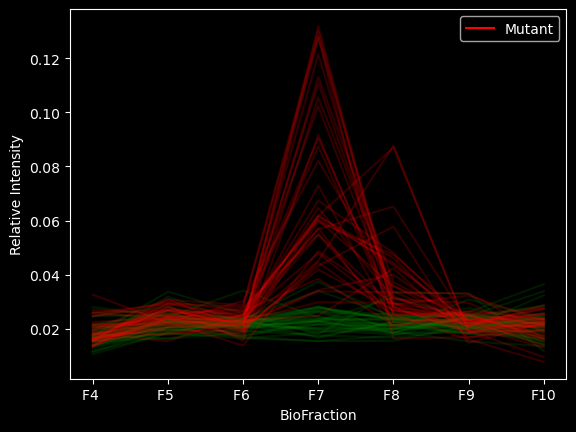

Plotting only mixture M3 for module 8.
analyzing ONLY mixture M3
7 ###################
Directory 'SNCA_MixtureM3' already exists.
SNCA_MixtureM3/SNCA_Module8_MixtureM3.png file created!
This is the filepath /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/compare_MutvsWTfractions/SNCA_MixtureM3/SNCA_Module8_MixtureM3.png


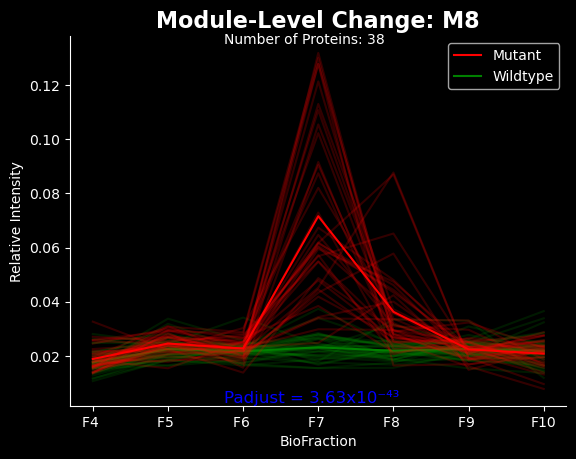

6
Mixture analyzing M3
Moving to next module 6 

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']

Number of proteins in module M6: 57

PadjustScore for module M6: 1.564696829072403e-12

In this dataset, the wildtype is classified as 'WildType' and the mutant is classified as 'Transgenic'


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


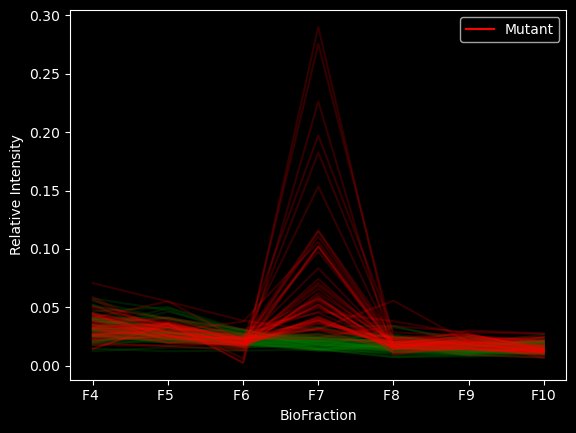

Plotting only mixture M3 for module 6.
analyzing ONLY mixture M3
7 ###################
Directory 'SNCA_MixtureM3' already exists.
SNCA_MixtureM3/SNCA_Module6_MixtureM3.png file created!
This is the filepath /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/compare_MutvsWTfractions/SNCA_MixtureM3/SNCA_Module6_MixtureM3.png


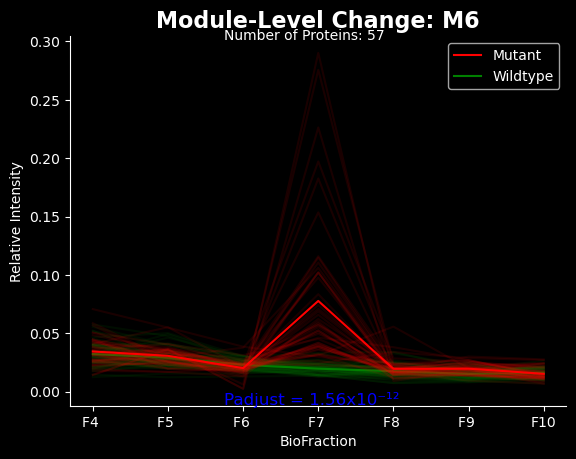

12
Mixture analyzing M3
Moving to next module 12 

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']

Number of proteins in module M12: 28

PadjustScore for module M12: 7.279067577575928e-10

In this dataset, the wildtype is classified as 'WildType' and the mutant is classified as 'Transgenic'


100%|██████████| 24/24 [00:09<00:00,  2.46it/s]


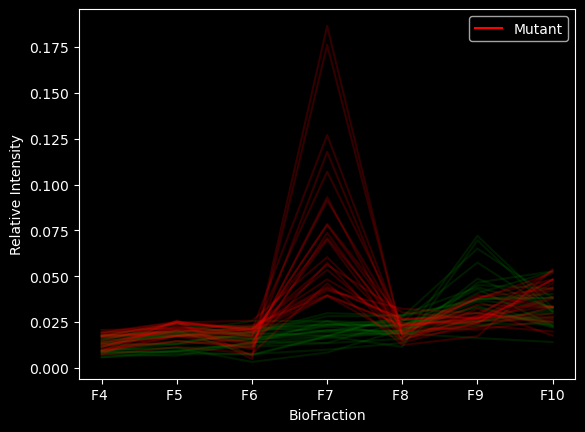

Plotting only mixture M3 for module 12.
analyzing ONLY mixture M3
7 ###################
Directory 'SNCA_MixtureM3' already exists.
SNCA_MixtureM3/SNCA_Module12_MixtureM3.png file created!
This is the filepath /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/compare_MutvsWTfractions/SNCA_MixtureM3/SNCA_Module12_MixtureM3.png


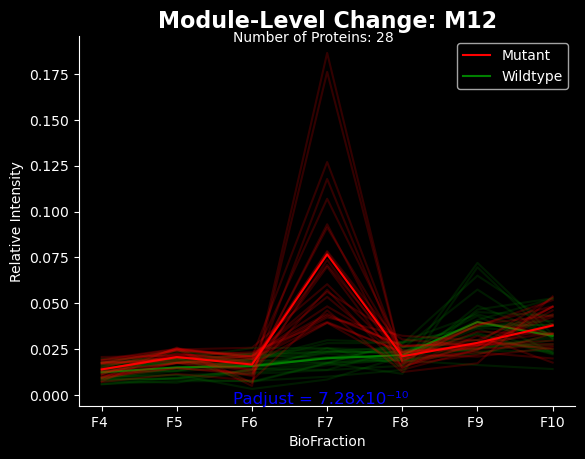

11
Mixture analyzing M3
Moving to next module 11 

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']

Number of proteins in module M11: 30

PadjustScore for module M11: 5.602458764045302e-06

In this dataset, the wildtype is classified as 'WildType' and the mutant is classified as 'Transgenic'


100%|██████████| 27/27 [00:10<00:00,  2.46it/s]


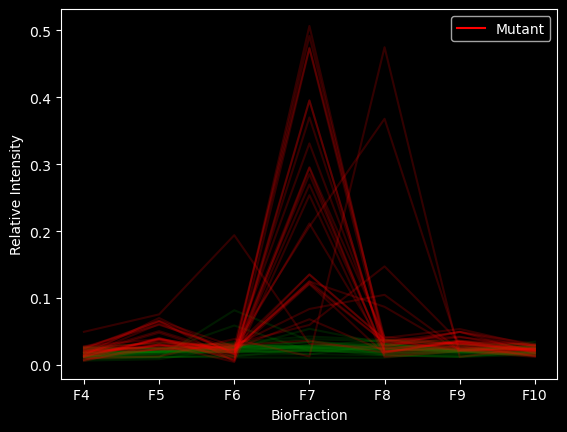

Plotting only mixture M3 for module 11.
analyzing ONLY mixture M3
7 ###################
Directory 'SNCA_MixtureM3' already exists.
SNCA_MixtureM3/SNCA_Module11_MixtureM3.png file created!
This is the filepath /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/compare_MutvsWTfractions/SNCA_MixtureM3/SNCA_Module11_MixtureM3.png


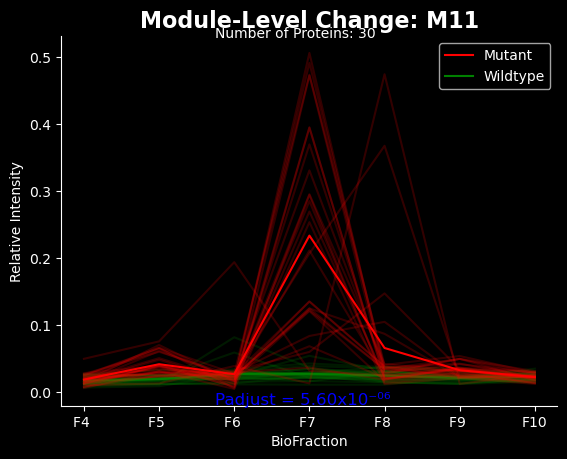

5
Mixture analyzing M3
Moving to next module 5 

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']

Number of proteins in module M5: 61

PadjustScore for module M5: 2.243707008729295e-05

In this dataset, the wildtype is classified as 'WildType' and the mutant is classified as 'Transgenic'


100%|██████████| 60/60 [00:24<00:00,  2.47it/s]


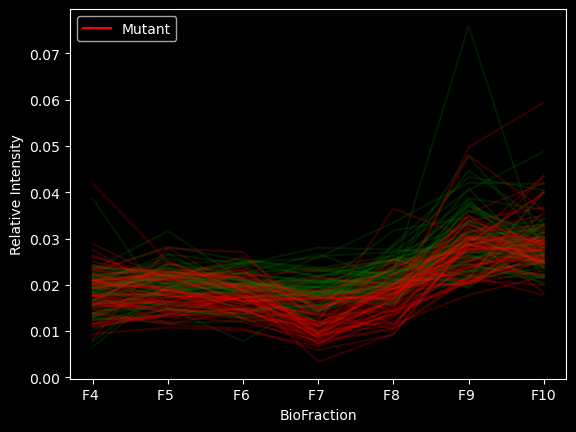

Plotting only mixture M3 for module 5.
analyzing ONLY mixture M3
7 ###################
Directory 'SNCA_MixtureM3' already exists.
SNCA_MixtureM3/SNCA_Module5_MixtureM3.png file created!
This is the filepath /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/compare_MutvsWTfractions/SNCA_MixtureM3/SNCA_Module5_MixtureM3.png


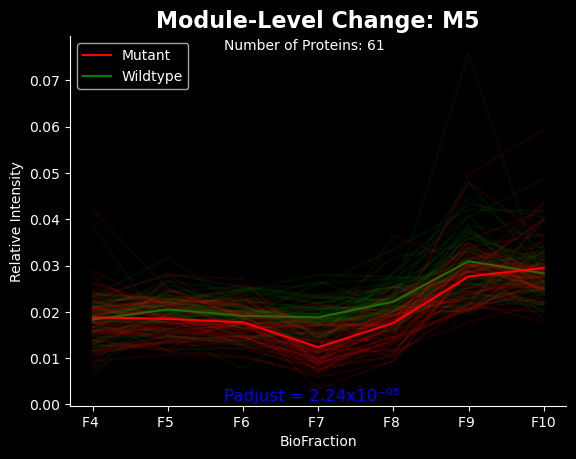

4
Mixture analyzing M3
Moving to next module 4 

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']

Number of proteins in module M4: 61

PadjustScore for module M4: 0.0009286679311302002

In this dataset, the wildtype is classified as 'WildType' and the mutant is classified as 'Transgenic'


100%|██████████| 59/59 [00:23<00:00,  2.46it/s]


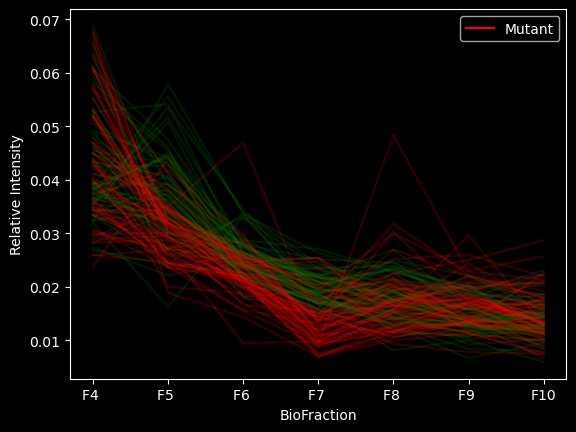

Plotting only mixture M3 for module 4.
analyzing ONLY mixture M3
7 ###################
Directory 'SNCA_MixtureM3' already exists.
SNCA_MixtureM3/SNCA_Module4_MixtureM3.png file created!
This is the filepath /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/compare_MutvsWTfractions/SNCA_MixtureM3/SNCA_Module4_MixtureM3.png


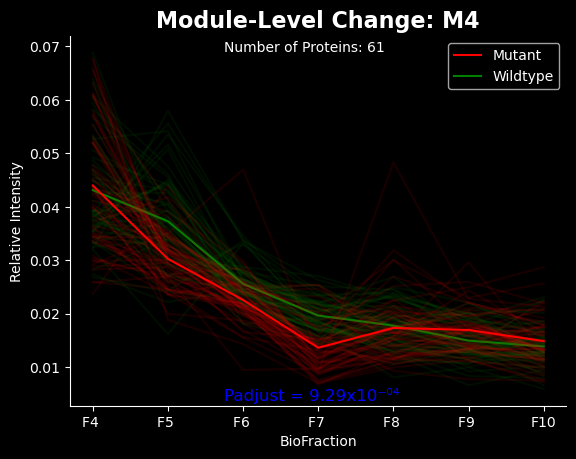

15
Mixture analyzing M3
Moving to next module 15 

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']

Number of proteins in module M15: 12

PadjustScore for module M15: 0.001375975795023081

In this dataset, the wildtype is classified as 'WildType' and the mutant is classified as 'Transgenic'


100%|██████████| 12/12 [00:04<00:00,  2.52it/s]


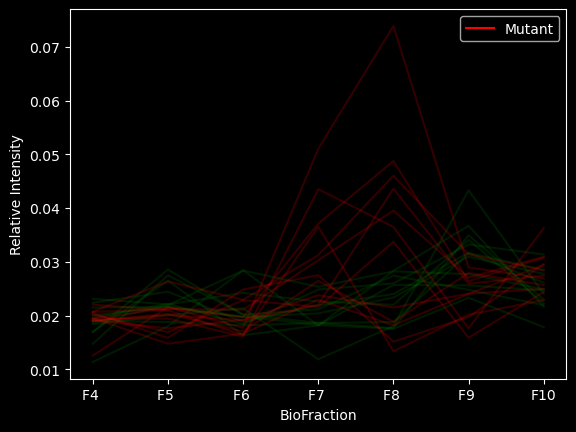

Plotting only mixture M3 for module 15.
analyzing ONLY mixture M3
7 ###################
Directory 'SNCA_MixtureM3' already exists.
SNCA_MixtureM3/SNCA_Module15_MixtureM3.png file created!
This is the filepath /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/compare_MutvsWTfractions/SNCA_MixtureM3/SNCA_Module15_MixtureM3.png


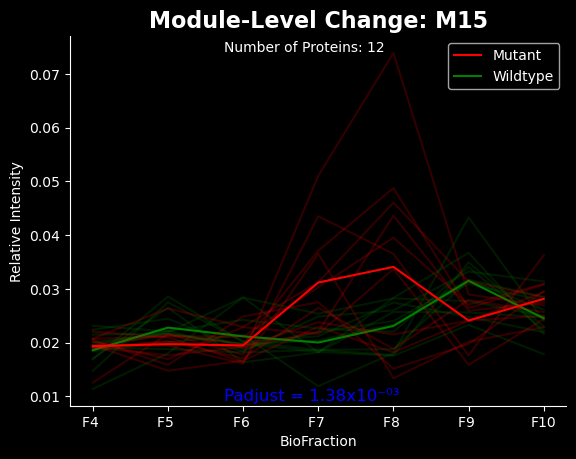

7
Mixture analyzing M3
Moving to next module 7 

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']

Number of proteins in module M7: 40

PadjustScore for module M7: 0.001540134933218731

In this dataset, the wildtype is classified as 'WildType' and the mutant is classified as 'Transgenic'


100%|██████████| 40/40 [00:16<00:00,  2.49it/s]


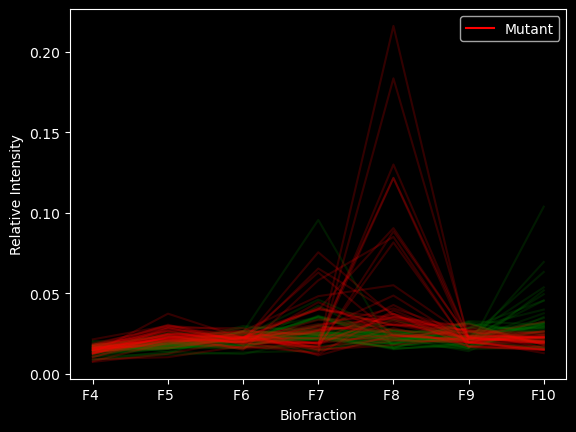

Plotting only mixture M3 for module 7.
analyzing ONLY mixture M3
7 ###################
Directory 'SNCA_MixtureM3' already exists.
SNCA_MixtureM3/SNCA_Module7_MixtureM3.png file created!
This is the filepath /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/compare_MutvsWTfractions/SNCA_MixtureM3/SNCA_Module7_MixtureM3.png


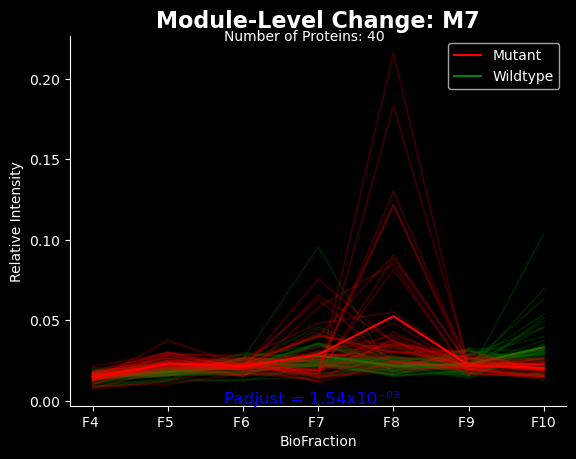

14
Mixture analyzing M3
Moving to next module 14 

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']

Number of proteins in module M14: 22

PadjustScore for module M14: 0.01558964563409878

In this dataset, the wildtype is classified as 'WildType' and the mutant is classified as 'Transgenic'


100%|██████████| 21/21 [00:08<00:00,  2.48it/s]


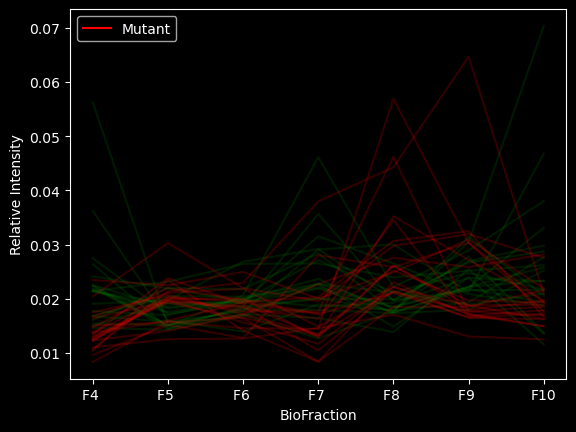

Plotting only mixture M3 for module 14.
analyzing ONLY mixture M3
7 ###################
Directory 'SNCA_MixtureM3' already exists.
SNCA_MixtureM3/SNCA_Module14_MixtureM3.png file created!
This is the filepath /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/compare_MutvsWTfractions/SNCA_MixtureM3/SNCA_Module14_MixtureM3.png


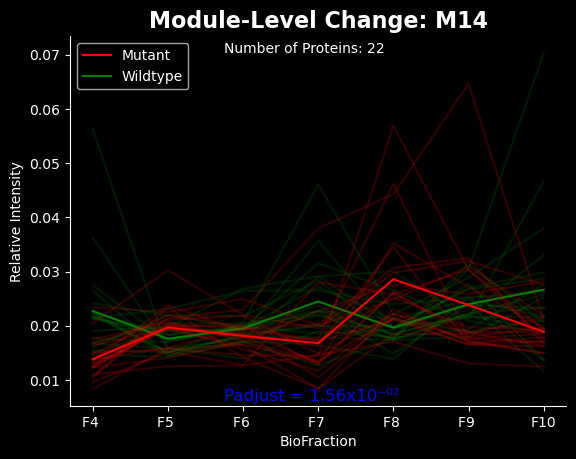

13
Mixture analyzing M3
Moving to next module 13 

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']

Number of proteins in module M13: 24

PadjustScore for module M13: 0.04403348971207673

In this dataset, the wildtype is classified as 'WildType' and the mutant is classified as 'Transgenic'


100%|██████████| 23/23 [00:09<00:00,  2.47it/s]


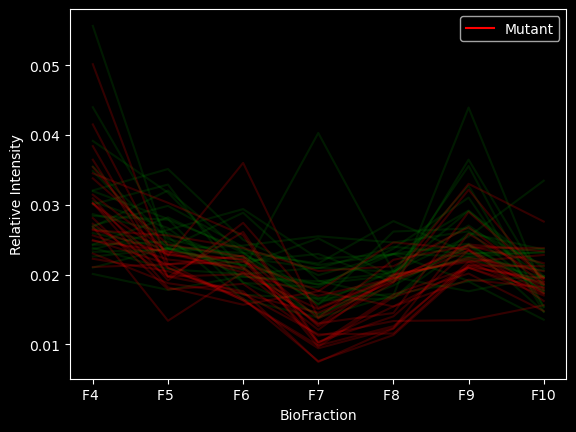

Plotting only mixture M3 for module 13.
analyzing ONLY mixture M3
7 ###################
Directory 'SNCA_MixtureM3' already exists.
SNCA_MixtureM3/SNCA_Module13_MixtureM3.png file created!
This is the filepath /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/compare_MutvsWTfractions/SNCA_MixtureM3/SNCA_Module13_MixtureM3.png


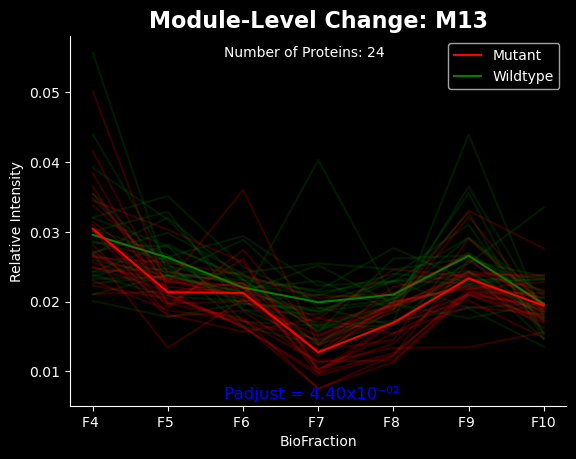

In [90]:
import re
def main():
    global mixture_to_analyze, gene_analyzing, foldername, currentdir, abspath, transformedfile, module_results_file
    global wildtype, mutant, proteins, fractions, genes, mixtures

    average_mixtures = False  # True to average all mixtures
    mixture_to_analyze = "M3"  # Specify mixture; ignored if averaging
    significant_module = 2  # None to analyze all modules

    # Common initial steps
    geneAnalysis, transformeddatadf, partition_df = read_files(gene_analyzing, transformedfile, module_results_file)
    alldata_df = merge_dataframes(transformeddatadf, partition_df)
    newdf = drop_irrelevant_cols(alldata_df)

    # Determine modules to analyze
    module_details_df, nprots, pAdjustScore, sigmodules = pick_module(None)
    sigmodules = [int(re.search(r'\d+', element).group()) for element in sigmodules if re.search(r'\d+', element)]
    print("modules to analyze", sigmodules)
    for module in sigmodules:
        print(module)
        print(f"Mixture analyzing {mixture_to_analyze}")
        print(f"Moving to next module {module} \n")
        module_details_df, nprots, pAdjustScore, sigmodules = pick_module(module)
        proteins, genes, fractions, mixtures = analyze_data(newdf, wildtype, mutant, module)
        wildtype_dict = pull_Module_WT_data(newdf, proteins, genes, fractions, mixtures)
        plot_wt(wildtype_dict, mixture_to_analyze)
        mutant_dict = pull_Module_MUT_data(newdf, proteins, genes, fractions, mixtures)
        plot_MUT(mutant_dict, mixture_to_analyze)

        if average_mixtures:
            print(f"Averaging all mixtures, and creating plot of averages for module {module}.")
            find_avg_plots(wildtype_dict, mutant_dict, module, pAdjustScore, nprots, mixtures)
        else:
            print(f"Plotting only mixture {mixture_to_analyze} for module {module}.")
            WT, MUT, mixture_to_analyze = plot_MUTWT_1mix(wildtype_dict, mutant_dict, module, pAdjustScore, nprots, mixture_to_analyze)

    return

main()

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']

modules to analyze ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']
Mixture analyzing M3
Moving to next module M8 

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']

Number of proteins in module M8: 38

PadjustScore for module M8: 3.630775577528712e-43

In this dataset, the wildtype is classified as 'WildType' and the mutant is classified as 'Transgenic'


0it [00:00, ?it/s]
0it [00:00, ?it/s]


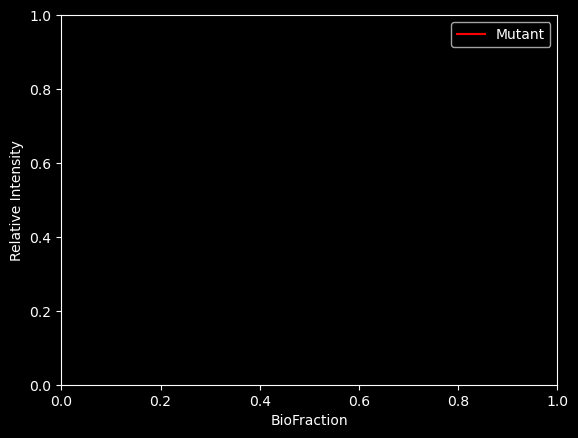

Averaging all mixtures, and creating plot of averages for module M8.
analyzing ALL mixtures: []


/home/poojaparameswaran/anaconda3/envs/dataenv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/poojaparameswaran/anaconda3/envs/dataenv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TypeError: object of type 'numpy.float64' has no len()

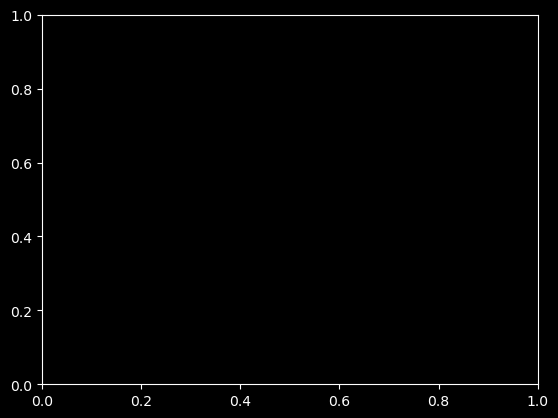

In [85]:
if __name__ == "__main__":

    main()